In [19]:
runs = 200

In [20]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0
        !pip install tensorflow-probability==0.8.0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0  running in colab?:  False


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
import urllib.request
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)


TFP Version 0.8.0
TF  Version 2.0.0


In [22]:
def create_sine_data(n = 300):
    np.random.seed(32)
    n = 300
    x = np.linspace(0,1*2*np.pi,n)
    y1 = 3*np.sin(x)
    y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
    x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
    y2 = 0.1*x+1
    y=y1+y2
    return x,y

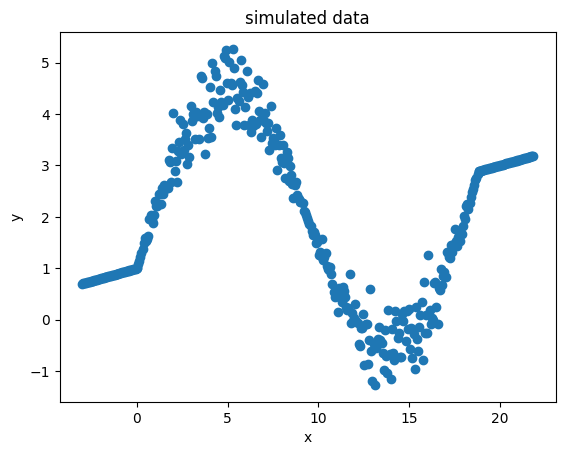

In [23]:
## use custom function to simulate some data 
x,y = create_sine_data(n=300) #A
plt.scatter(x=x,y=y,marker='o')
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

## Non-Bayesian (just aleatoric)

We create a non-Bayesian model for the mean $\mu_x$ and the standard deviation $\sigma_x$

In [24]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



def NLL(y, distr): 
  return -distr.log_prob(y) 

def my_dist(params): 
  return tfd.Normal(loc=params[:,0:1], scale=1e-3 + tf.math.softplus(0.05 * params[:,1:2]))# both parameters are learnable

inputs = Input(shape=(1,))
hidden = Dense(20,activation="relu")(inputs)
hidden = Dense(50,activation="relu")(hidden)
hidden = Dense(20,activation="relu")(hidden)
params = Dense(2)(hidden)
dist = tfp.layers.DistributionLambda(my_dist)(params) 

model_aleatoric = Model(inputs=inputs, outputs=dist)
model_aleatoric.compile(Adam(), loss=NLL) 

In [25]:
model_aleatoric.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_5 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_6 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 42        
_________________________________________________________________
distribution_lambda_2 (Distr ((None, 1), (None, 1))    0         
Total params: 2,152
Trainable params: 2,152
Non-trainable params: 0
_________________________________________________________

In [26]:
#history = model_aleatoric.fit(x, y, epochs=5000, verbose=0,batch_size=32)

In [27]:
#plt.plot(history.history['loss'])
#plt.legend(['loss'])
#plt.ylabel('NLL')
#plt.xlabel('Epochs')
#plt.show()

In [28]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_weights.hdf5", "model_aleatoric_weights.hdf5")
model_aleatoric.load_weights("model_aleatoric_weights.hdf5")

In [29]:
model_aleatoric_mean = Model(inputs=inputs, outputs=dist.mean())
model_aleatoric_sd = Model(inputs=inputs, outputs=dist.stddev())

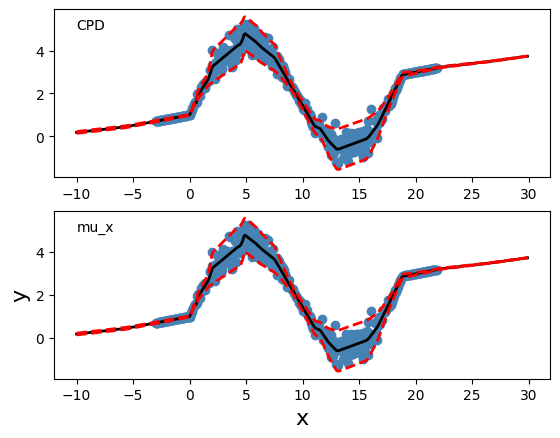

In [30]:
def make_no_bayes_plot(ax, text, model_mu, model_sig, add_std=False):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue") #observerd 
    mus_pred = model_mu.predict(x_pred)
    sig_pred = model_sig.predict(x_pred)
    ax.plot(x_pred,mus_pred,color="black",linewidth=2)
    if add_std:
        ax.plot(x_pred,mus_pred + 2 * sig_pred,color="red",linestyle="--",linewidth=2) 
        ax.plot(x_pred,mus_pred - 2 * sig_pred,color="red",linestyle="--",linewidth=2)
    ax.text(-10,5,text)

f,ax = plt.subplots(2)
make_no_bayes_plot(ax[0],"CPD", model_aleatoric_mean, model_aleatoric_sd, add_std=True)
make_no_bayes_plot(ax[1],r"mu_x", model_aleatoric_mean, model_aleatoric_sd, add_std=True)
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## Bayesian Model using VI

In [31]:
kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x.shape[0] * 1.0)


inputs = Input(shape=(1,))


hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(inputs)
hidden = tfp.layers.DenseFlipout(50,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
hidden = tfp.layers.DenseFlipout(20,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn,activation="relu")(hidden)
params = tfp.layers.DenseFlipout(2,bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn)(hidden)
dist = tfp.layers.DistributionLambda(my_dist)(params) 


model_vi = Model(inputs=inputs, outputs=dist)
model_vi.compile(Adam(), loss=NLL) 

In [32]:
model_vi.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_flipout_4 (DenseFlipou (None, 20)                80        
_________________________________________________________________
dense_flipout_5 (DenseFlipou (None, 50)                2100      
_________________________________________________________________
dense_flipout_6 (DenseFlipou (None, 20)                2040      
_________________________________________________________________
dense_flipout_7 (DenseFlipou (None, 2)                 84        
_________________________________________________________________
distribution_lambda_3 (Distr ((None, 1), (None, 1))    0         
Total params: 4,304
Trainable params: 4,304
Non-trainable params: 0
_________________________________________________________

In [33]:
#history = model_aleatoric_epistemic.fit(x, y, epochs=20000, verbose=0,batch_size=32)
# around 10 min

In [34]:
#plt.plot(history.history['loss'])
#plt.legend(['loss'])
#plt.ylabel('NLL')
#plt.xlabel('Epochs')
#plt.ylim([0,20])
#plt.show()

In [35]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_aleatoric_epistemic_weights.hdf5", "model_aleatoric_epistemic_weights.hdf5")
model_vi.load_weights("model_aleatoric_epistemic_weights.hdf5")

model_vi_mean = Model(inputs=inputs, outputs=dist.mean())
model_vi_sd = Model(inputs=inputs, outputs=dist.stddev())

In [110]:
# Predicting the mu and sigma
x_pred = np.arange(-10,30,0.1)
vi_mus =np.zeros((runs,len(x_pred)))
vi_stds=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_mus[i,:]=np.reshape(model_vi_mean.predict(x_pred),len(x_pred))
    vi_stds[i,:]=np.reshape(model_vi_sd.predict(x_pred),len(x_pred))

### Parameter $\mu_x$ for several runs 

We start several runs and plot the parameters $\mu_x$

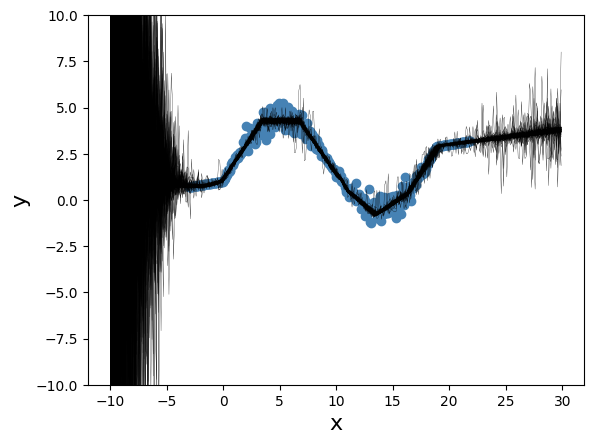

In [37]:
def make_bayes_plot_runs(ax, preds, runs = 100):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue") #observerd 
    for i in range(0,runs):
      ax.plot(x_pred, preds[i,0:400],color="black",linewidth=0.2)
  
ax = plt.subplot()
make_bayes_plot_runs(ax, vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

#### Taking statistics of the different runs 

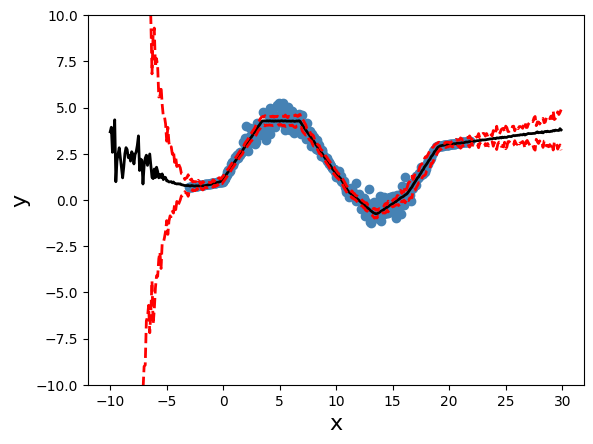

In [109]:
def make_bayes_plot_runs_avg(ax, preds, runs = 100):
    x_pred = np.arange(-10,30,0.1)
    ax.scatter(x,y,color="steelblue") #observerd     
    ax.plot(x_pred,np.mean(preds,axis=0),color="black",linewidth=2)
    ax.plot(x_pred,np.mean(preds,axis=0)+2*np.std(preds,axis=0),color="red",linewidth=2,linestyle="--")
    ax.plot(x_pred,np.mean(preds,axis=0)-2*np.std(preds,axis=0),color="red",linewidth=2,linestyle="--")

ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_mus)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## Modeling the CPD


In [112]:
x_pred = np.arange(-10,30,0.1)
vi_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    vi_cpd[i,:]=np.reshape(model_vi.predict(x_pred),len(x_pred))

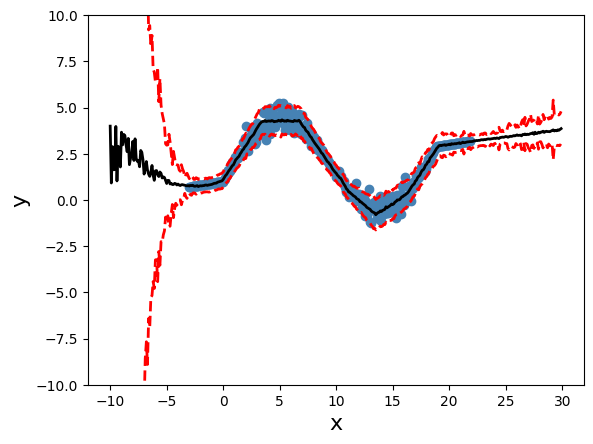

In [113]:
ax = plt.subplot()
make_bayes_plot_runs_avg(ax,vi_cpd)
plt.ylim([-10,10])
plt.xlabel("x",size=16)
plt.ylabel("y",size=16)
plt.show()

## MC Dropout

In [57]:
# define loss function that corresponds to NLL  
# import math
# def my_NLL_loss(y_true,y_pred):
#   mu=tf.slice(y_pred,[0,0],[-1,1])              # A     
#   sigma=tf.math.exp(tf.slice(y_pred,[0,1],[-1,1]))   # B 
  
#   a=1/(tf.sqrt(2.*math.pi)*sigma) 
#   b1=tf.square(mu-y_true)
#   b2=2*tf.square(sigma)
#   b=b1/b2
  
#   loss = tf.reduce_sum(-tf.math.log(a)+b,axis=0)
#   return loss

#A extract first column for μ 
#B extract second column for σ

In [58]:
from tensorflow.keras.layers import Dropout

inputs = Input(shape=(1,))
hidden = Dense(200,activation="relu")(inputs)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(500,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
hidden = Dense(200,activation="relu")(hidden)
hidden = Dropout(0.1)(hidden, training=True)
params_mc = Dense(2)(hidden)
dist_mc = tfp.layers.DistributionLambda(my_dist)(params_mc) 

model_mc = Model(inputs=inputs, outputs=dist_mc)
model_mc.compile(Adam(), loss=NLL) 

In [59]:
model_mc.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_26 (Dense)             (None, 200)               400       
_________________________________________________________________
dropout_15 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 500)               100500    
_________________________________________________________________
dropout_16 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_17 (Dropout)         (None, 500)               0  

In [64]:
history = model_mc.fit(x, y, epochs=500, verbose=0,batch_size=32)
#dauert ca 20min mit 20000 epochs

Text(0.5, 0, 'Epochs')

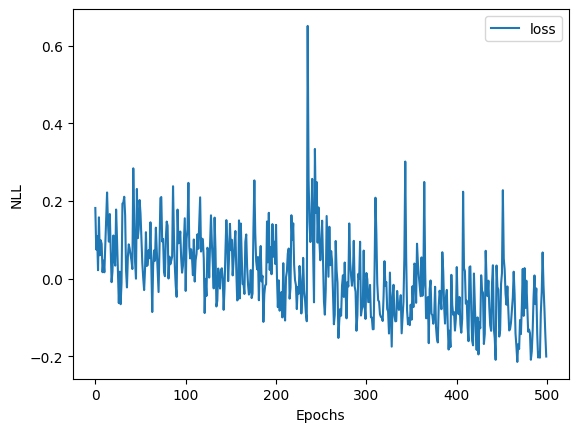

In [65]:
plt.plot(history.history['loss'])
plt.legend(['loss'])
plt.ylabel('NLL')
plt.xlabel('Epochs')

In [46]:
# download and load weights of the model
#urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_weights.hdf5", "model_mc_weights.hdf5")
#model_mc.load_weights("model_mc_weights.hdf5")

In [67]:
model_mc_mean = Model(inputs=inputs, outputs=dist_mc.mean())
model_mc_sd = Model(inputs=inputs, outputs=dist_mc.stddev())

In [102]:
# Predicting the mu and sigma

mc_mus=np.zeros((runs,len(x_pred)))
mc_std=np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
  mc_mus[i,:]=np.reshape(model_mc_mean.predict(x_pred),len(x_pred))
  mc_std[i,:]=np.reshape(model_mc_sd.predict(x_pred),len(x_pred))

In [103]:
x_pred = np.arange(-10,30,0.1)
mc_cpd =np.zeros((runs,len(x_pred)))
for i in tqdm(range(0,runs)):
    mc_cpd[i,:]=np.reshape(model_mc.predict(x_pred),len(x_pred))

<Figure size 1000x1000 with 0 Axes>

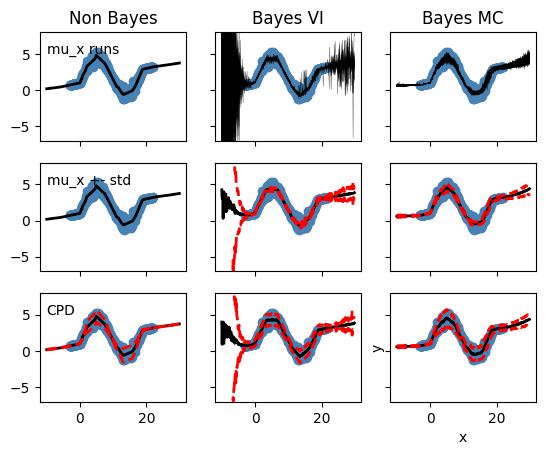

In [114]:
plt.figure(figsize=(10,10))
f,ax = plt.subplots(3,3,sharex=True, sharey=True)
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-7,8])

make_no_bayes_plot(ax[0,0],r"mu_x runs", model_aleatoric_mean, model_aleatoric_sd, add_std=False)
ax[0,0].set_title('Non Bayes')
make_no_bayes_plot(ax[1,0],r"mu_x +- std", model_aleatoric_mean, model_aleatoric_sd, add_std=False)
make_no_bayes_plot(ax[2,0],r"CPD", model_aleatoric_mean, model_aleatoric_sd, add_std=True)

ax[0,1].set_title('Bayes VI')
make_bayes_plot_runs(ax[0,1], vi_mus)
make_bayes_plot_runs_avg(ax[1,1], vi_mus)
make_bayes_plot_runs_avg(ax[2,1], vi_cpd)

ax[0,2].set_title('Bayes MC')
make_bayes_plot_runs(ax[0,2], mc_mus)
make_bayes_plot_runs_avg(ax[1,2], mc_mus)
make_bayes_plot_runs_avg(ax[2,2], mc_cpd)
plt.savefig('ch08_good.pdf')

plt.show()

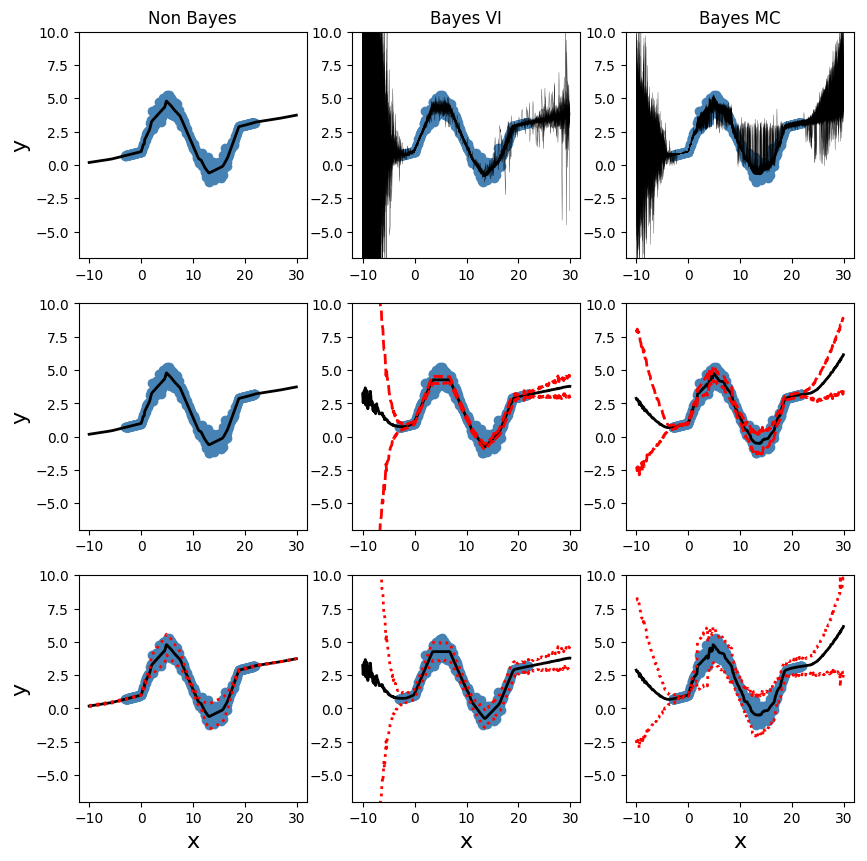

In [39]:
plt.figure(figsize=(10,10))
plt.subplot(3,3,1)
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.ylim([-7,10])
plt.title("Non Bayes")
plt.ylabel("y",fontsize=16)

plt.subplot(3,3,2)
plt.scatter(x,y,color="steelblue") #observerd 
for i in range(0,100):
  plt.plot(x_pred,np.reshape(model_aleatoric_epistemic_mean.predict(x_pred),len(x_pred)),color="black",linewidth=0.2)
  plt.ylim([-7,10])
plt.title("Bayes VI")

plt.subplot(3,3,3)
plt.scatter(x,y,color="steelblue") #observerd 
for i in range(0,100):
  plt.plot(x_pred,model_mc.predict(x_pred)[:,0],color="black",linewidth=0.2)
  plt.ylim([-7,10])
plt.title("Bayes MC")

plt.subplot(3,3,4) 
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.ylim([-7,10])
plt.ylabel("y",fontsize=16)



plt.subplot(3,3,5)  
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_vi,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)+2*np.std(n_preds_vi,axis=0),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)-2*np.std(n_preds_vi,axis=0),color="red",linestyle="--",linewidth=2)
plt.ylim([-7,10])

plt.subplot(3,3,6)
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_mc,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)+2*np.std(n_preds_mc,axis=0),color="red",linestyle="--",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)-2*np.std(n_preds_mc,axis=0),color="red",linestyle="--",linewidth=2)
plt.ylim([-7,10])

plt.subplot(3,3,7)
plt.scatter(x,y,color="steelblue") #observerd 
preds = model_aleatoric_mean.predict(x_pred)
plt.plot(x_pred,preds,color="black",linewidth=2)
plt.plot(x_pred,preds+2*model_aleatoric_sd.predict(x_pred),color="red",linestyle=":",linewidth=2) 
plt.plot(x_pred,preds-2*model_aleatoric_sd.predict(x_pred),color="red",linestyle=":",linewidth=2)
plt.ylim([-7,10])
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)

plt.subplot(3,3,8)  
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_vi,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)+2*np.std(n_preds_vi,axis=0)+np.mean(n_preds_std_vi,axis=0)+2*+np.std(n_preds_std_vi,axis=0),color="red",linestyle=":",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_vi,axis=0)-2*np.std(n_preds_vi,axis=0)-np.mean(n_preds_std_vi,axis=0)-2*+np.std(n_preds_std_vi,axis=0),color="red",linestyle=":",linewidth=2)
plt.ylim([-7,10])
plt.xlabel("x",fontsize=16)

plt.subplot(3,3,9)
plt.scatter(x,y,color="steelblue") #observerd 
plt.plot(x_pred,np.mean(n_preds_mc,axis=0),color="black",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)+2*np.std(n_preds_mc,axis=0)+np.mean(n_preds_mc_std,axis=0)+2*+np.std(n_preds_mc_std,axis=0),color="red",linestyle=":",linewidth=2)
plt.plot(x_pred,np.mean(n_preds_mc,axis=0)-2*np.std(n_preds_mc,axis=0)-np.mean(n_preds_mc_std,axis=0)-2*+np.std(n_preds_mc_std,axis=0),color="red",linestyle=":",linewidth=2)
plt.ylim([-7,10])
plt.xlabel("x",fontsize=16)
plt.show()